# Сегментация камней

### Разархивация всех данных

In [18]:
!unzip -o "/storage/vskovoroda/Stones/full_dataset.zip" -d "/storage/vskovoroda/Stones/"

Archive:  /storage/vskovoroda/Stones/full_dataset.zip
  inflating: /storage/vskovoroda/Stones/Asbest veins in the open pit conditions/parts45769.zip  
  inflating: /storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part2.zip  
  inflating: /storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part1.zip  
  inflating: /storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part11.zip  
  inflating: /storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part3.zip  


In [19]:
!mv -f "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions/parts45769.zip" -t "/storage/vskovoroda/Stones/"
!mv -f "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part2.zip" -t "/storage/vskovoroda/Stones/"
!mv -f "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part1.zip" -t "/storage/vskovoroda/Stones/"
!mv -f "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part11.zip" -t "/storage/vskovoroda/Stones/"
!mv -f "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions/part3.zip" -t "/storage/vskovoroda/Stones/"

In [20]:
!rm -d "/storage/vskovoroda/Stones/Asbest veins in the open pit conditions"
!mkdir "/storage/vskovoroda/Stones/data/"
!mkdir "/storage/vskovoroda/Stones/data/part1"\
        "/storage/vskovoroda/Stones/data/part2"\
        "/storage/vskovoroda/Stones/data/part3"\
        "/storage/vskovoroda/Stones/data/part4"\
        "/storage/vskovoroda/Stones/data/part5"

mkdir: cannot create directory ‘/storage/vskovoroda/Stones/data/’: File exists


In [21]:
!unzip -qq -o "/storage/vskovoroda/Stones/part1.zip" -d "/storage/vskovoroda/Stones/data/part1"
!unzip -qq -o "/storage/vskovoroda/Stones/part2.zip" -d "/storage/vskovoroda/Stones/data/part2"
!unzip -qq -o "/storage/vskovoroda/Stones/part3.zip" -d "/storage/vskovoroda/Stones/data/part3"
!unzip -qq -o "/storage/vskovoroda/Stones/part11.zip" -d "/storage/vskovoroda/Stones/data/part4"
!unzip -qq -o "/storage/vskovoroda/Stones/parts45769.zip" -d "/storage/vskovoroda/Stones/data/part5"

In [8]:
!rm "/storage/vskovoroda/Stones/part1.zip"
!rm "/storage/vskovoroda/Stones/part2.zip"
!rm "/storage/vskovoroda/Stones/part3.zip"
!rm "/storage/vskovoroda/Stones/part11.zip"
!rm "/storage/vskovoroda/Stones/parts45769.zip"

### Импорт всех необходимых библиотек

In [1]:
from pycocotools.coco import COCO
import cv2
import os
import json
import numpy as np
import multiprocessing

from fastai.vision.all import *
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
start_dir = "/storage/vskovoroda/Stones/data/"
os.chdir(start_dir)

In [4]:
os.listdir()

['part3',
 'runs',
 'part5',
 'model_20230219_024028_0',
 'part4',
 'part2',
 'annotations',
 'model_20230219_030932_0',
 'models',
 'images',
 'part1',
 'model_20230219_024209_0']

## Создаине DataBlock для обучения моделей

In [5]:
codes = ['no_asbest', 'asbest']
data_path = Path('/storage/vskovoroda/Stones/data')
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items=get_image_files,
                splitter=RandomSplitter(),
                get_y=lambda o: data_path/'annotations'/o.name,
                batch_tfms=[Normalize.from_stats(*imagenet_stats), aug_transforms]
               )

In [6]:
dls = binary.dataloaders(data_path/'images', bs=2)

In [5]:
path = Path('/storage/vskovoroda/Stones/data')
dls = SegmentationDataLoaders.from_label_func(path = path,
            bs = 10,
            item_tfms = RandomCrop(480),
            batch_tfms=[Normalize.from_stats(*imagenet_stats), 
                        *aug_transforms(
                            mult=1.0,
                            do_flip=True,
                            flip_vert=True,
                            max_rotate=45.0,
                            max_lighting=0.0,
                            max_warp=0.0,
                            p_affine=0.8,
                            max_zoom = 1.0,
                            pad_mode=PadMode.Zeros
                    )],
            fnames = get_image_files(path/'images'),
            label_func = lambda o: path/'annotations'/o.name,
            codes = ['no_asbest', 'asbest'])

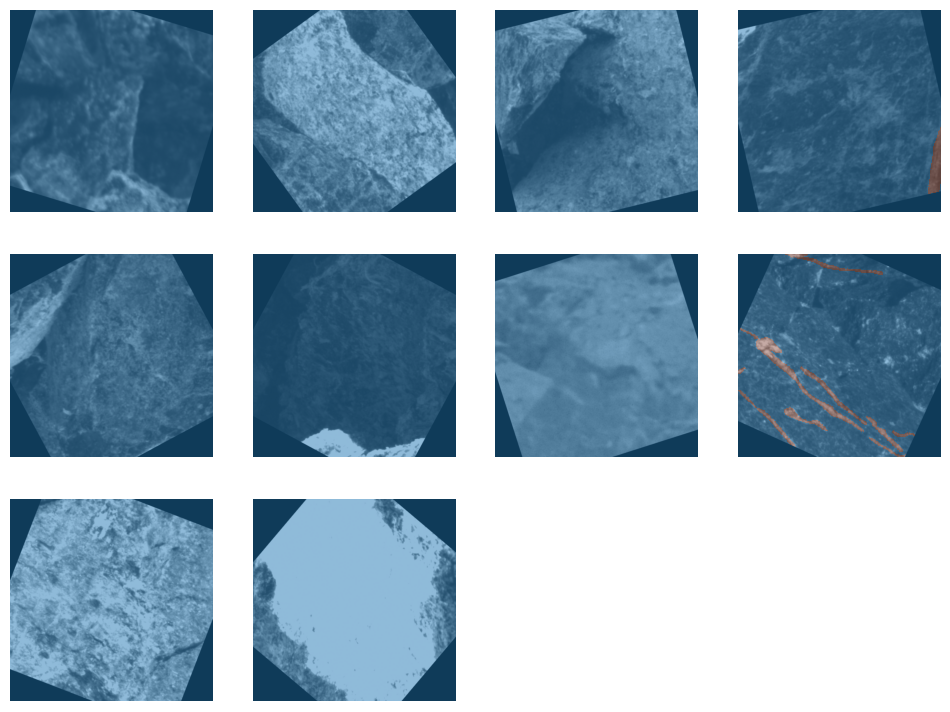

In [6]:
dls.show_batch(max_n=10)

In [24]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    activation = 'sigmoid',
    in_channels=3,
    classes=1,
)
model.cuda()
None

In [33]:
learn = Learner(dls, model, loss_func=smp.losses.DiceLoss(mode='binary'),
            metrics=[DiceLoss(),
                     smp.losses.TverskyLoss(mode='binary'),
                     smp.losses.JaccardLoss(mode='binary'),
                     smp.losses.FocalLoss(mode='binary'),
                     smp.losses.LovaszLoss(mode='binary'),
                     smp.losses.MCCLoss()
                    ])

In [11]:
learn = unet_learner(dls, resnet34, loss_func=DiceLoss(), y_range=(0,1),
                pretrained = False)

In [12]:
# learn.summary()

In [36]:
learn.metrics.names = ['a', 'b', 'c', 'd', 'e', 'f']

SuggestedLRs(valley=0.0012022644514217973)

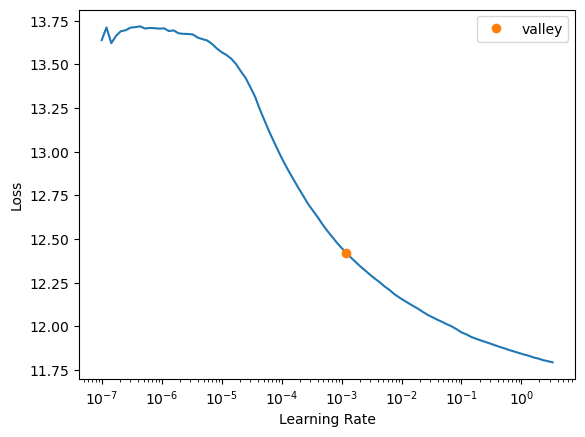

In [13]:
learn.lr_find()

In [14]:
learn.fit(2, lr=1e-2)

epoch,train_loss,valid_loss,time
0,11.503579,11.393163,01:09
1,11.489302,11.393163,01:09


In [16]:
learn.load('PAN')

In [ ]:
model.eval()

In [13]:
# learn.fit(1)

In [ ]:
learn.save('Unet')

Path('models/Unett.pth')

In [19]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [9]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [10]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [11]:
learn.fit(20)

epoch,train_loss,valid_loss,time
0,0.002195,0.002470,16:00
1,0.001996,0.002470,15:59
2,0.002471,0.002470,15:58
3,0.002653,0.002470,15:59
4,0.001267,0.002470,15:59
5,0.003587,0.002470,16:00
6,0.003616,0.002470,16:00
7,0.003756,0.002470,15:59
8,0.002523,0.002470,15:59
9,0.002571,0.002470,15:59


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [25]:
learn.save('UnetPlusPlus')

Path('models/UnetPlusPlus.pth')

In [13]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [7]:
model = smp.MAnet(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [8]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [9]:
learn.fit(7)

epoch,train_loss,valid_loss,time
0,0.007864,0.008418,08:56
1,0.006587,0.008418,08:55
2,0.007289,0.008418,08:55
3,0.005713,0.008418,08:55


KeyboardInterrupt: 

In [11]:
learn.load('PAN')

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var". 
	Unexpected key(s) in state_dict: "decoder.fpa.branch1.1.conv.weight", "decoder.fpa.branch1.1.conv.bias", "decoder.fpa.branch1.1.bn.weight", "decoder.fpa.branch1.1.bn.bias", "decoder.fpa.branch1.1.bn.running_mean", "decoder.fpa.branch1.1.bn.running_var", "decoder.fpa.branch1.1.bn.num_batches_tracked", "decoder.fpa.mid.0.conv.weight", "decoder.fpa.mid.0.conv.bias", "decoder.fpa.mid.0.bn.weight", "decoder.fpa.mid.0.bn.bias", "decoder.fpa.mid.0.bn.running_mean", "decoder.fpa.mid.0.bn.running_var", "decoder.fpa.mid.0.bn.num_batches_tracked", "decoder.fpa.down1.1.conv.weight", "decoder.fpa.down1.1.conv.bias", "decoder.fpa.down1.1.bn.weight", "decoder.fpa.down1.1.bn.bias", "decoder.fpa.down1.1.bn.running_mean", "decoder.fpa.down1.1.bn.running_var", "decoder.fpa.down1.1.bn.num_batches_tracked", "decoder.fpa.down2.1.conv.weight", "decoder.fpa.down2.1.conv.bias", "decoder.fpa.down2.1.bn.weight", "decoder.fpa.down2.1.bn.bias", "decoder.fpa.down2.1.bn.running_mean", "decoder.fpa.down2.1.bn.running_var", "decoder.fpa.down2.1.bn.num_batches_tracked", "decoder.fpa.down3.1.conv.weight", "decoder.fpa.down3.1.conv.bias", "decoder.fpa.down3.1.bn.weight", "decoder.fpa.down3.1.bn.bias", "decoder.fpa.down3.1.bn.running_mean", "decoder.fpa.down3.1.bn.running_var", "decoder.fpa.down3.1.bn.num_batches_tracked", "decoder.fpa.down3.2.conv.weight", "decoder.fpa.down3.2.conv.bias", "decoder.fpa.down3.2.bn.weight", "decoder.fpa.down3.2.bn.bias", "decoder.fpa.down3.2.bn.running_mean", "decoder.fpa.down3.2.bn.running_var", "decoder.fpa.down3.2.bn.num_batches_tracked", "decoder.fpa.conv2.conv.weight", "decoder.fpa.conv2.conv.bias", "decoder.fpa.conv2.bn.weight", "decoder.fpa.conv2.bn.bias", "decoder.fpa.conv2.bn.running_mean", "decoder.fpa.conv2.bn.running_var", "decoder.fpa.conv2.bn.num_batches_tracked", "decoder.fpa.conv1.conv.weight", "decoder.fpa.conv1.conv.bias", "decoder.fpa.conv1.bn.weight", "decoder.fpa.conv1.bn.bias", "decoder.fpa.conv1.bn.running_mean", "decoder.fpa.conv1.bn.running_var", "decoder.fpa.conv1.bn.num_batches_tracked", "decoder.gau3.conv1.1.conv.weight", "decoder.gau3.conv1.1.conv.bias", "decoder.gau3.conv1.1.bn.weight", "decoder.gau3.conv1.1.bn.bias", "decoder.gau3.conv1.1.bn.running_mean", "decoder.gau3.conv1.1.bn.running_var", "decoder.gau3.conv1.1.bn.num_batches_tracked", "decoder.gau3.conv2.conv.weight", "decoder.gau3.conv2.conv.bias", "decoder.gau3.conv2.bn.weight", "decoder.gau3.conv2.bn.bias", "decoder.gau3.conv2.bn.running_mean", "decoder.gau3.conv2.bn.running_var", "decoder.gau3.conv2.bn.num_batches_tracked", "decoder.gau2.conv1.1.conv.weight", "decoder.gau2.conv1.1.conv.bias", "decoder.gau2.conv1.1.bn.weight", "decoder.gau2.conv1.1.bn.bias", "decoder.gau2.conv1.1.bn.running_mean", "decoder.gau2.conv1.1.bn.running_var", "decoder.gau2.conv1.1.bn.num_batches_tracked", "decoder.gau2.conv2.conv.weight", "decoder.gau2.conv2.conv.bias", "decoder.gau2.conv2.bn.weight", "decoder.gau2.conv2.bn.bias", "decoder.gau2.conv2.bn.running_mean", "decoder.gau2.conv2.bn.running_var", "decoder.gau2.conv2.bn.num_batches_tracked", "decoder.gau1.conv1.1.conv.weight", "decoder.gau1.conv1.1.conv.bias", "decoder.gau1.conv1.1.bn.weight", "decoder.gau1.conv1.1.bn.bias", "decoder.gau1.conv1.1.bn.running_mean", "decoder.gau1.conv1.1.bn.running_var", "decoder.gau1.conv1.1.bn.num_batches_tracked", "decoder.gau1.conv2.conv.weight", "decoder.gau1.conv2.conv.bias", "decoder.gau1.conv2.bn.weight", "decoder.gau1.conv2.bn.bias", "decoder.gau1.conv2.bn.running_mean", "decoder.gau1.conv2.bn.running_var", "decoder.gau1.conv2.bn.num_batches_tracked". 
	size mismatch for segmentation_head.0.weight: copying a param with shape torch.Size([1, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 16, 3, 3]).

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
model = smp.Linknet(
    encoder_name="resnet34", 
    encoder_weights=None,    
    in_channels=3,           
    classes=1,                
)

In [ ]:
learn = Learner(dls, model, loss_func=DiceLoss())

In [ ]:
learn.fit(20)

In [ ]:
learn.save('Linknet')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
#########################################

In [24]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,time
0,0.002813,0.002470,15:59


epoch,train_loss,valid_loss,time
0,0.002545,0.002470,16:00
1,0.002240,0.002470,15:59


In [ ]:
smp.Unet
smp.UnetPlusPlus
smp.MAnet
smp.Linknet
smp.PSPNet
smp.FPN
smp.PAN
smp.DeepLabV3
smp.DeepLabV3Plus

In [10]:
learn.fit(10)

epoch,train_loss,valid_loss,time
0,7.390676,0.671788,00:22
1,3.031313,0.646121,00:20
2,1.739566,0.640595,00:19
3,1.180953,0.580568,00:19
4,0.895410,0.518434,00:19
5,0.745128,0.538023,00:19
6,0.659185,0.576371,00:19
7,0.603883,0.521982,00:19
8,0.567518,0.561850,00:20
9,0.540553,0.491454,00:20


In [ ]:
learn.opt.

In [17]:
interp = SegmentationInterpretation.from_learner(learn)

In [18]:
interp.plot_top_losses(k=5)

RuntimeError: selected index k out of range

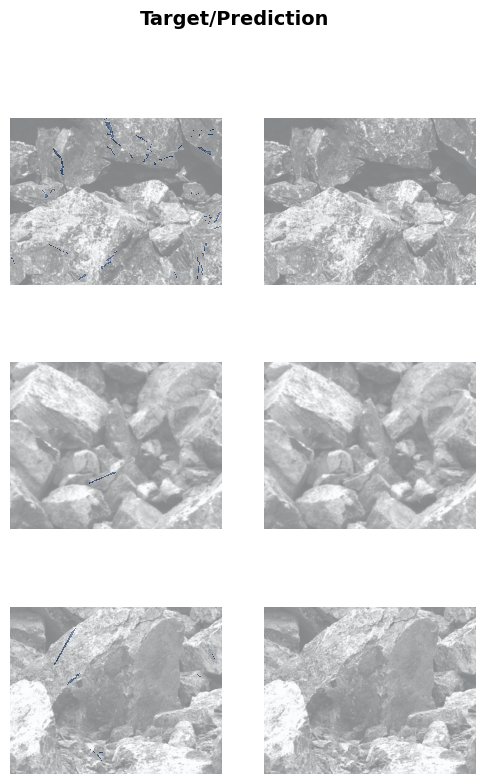

In [11]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [14]:
learn.load('40blur_7')

In [17]:
path = Path('data')
dls = SegmentationDataLoaders.from_label_func(path = path,
            item_tfms=Resize(600),
            bs = 5,
            batch_tfms=[Normalize.from_stats(*imagenet_stats), aug_transforms],
            fnames = get_image_files(path/'images'),
            label_func = lambda o: get_msk(o), codes = ['no_stone', 'stone'])

In [18]:
learn.dls = dls

In [18]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [22]:
imges_names = (path/'images').ls()
masks_names = (path/'SegmentationClass').ls()

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

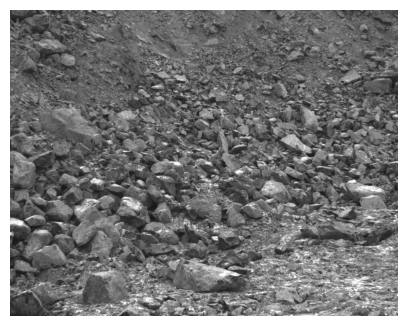

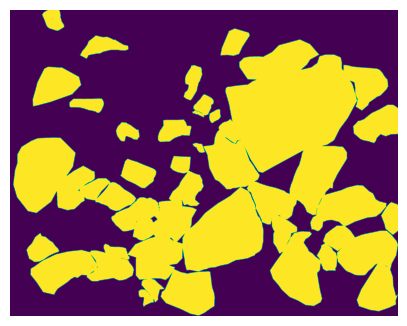

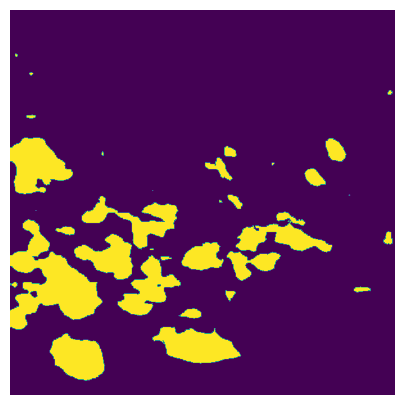

In [23]:
k = 2
img = PILImage.create(imges_names[k])
msk = PILMask.create(masks_names[k])
pred = learn.predict(PILImage.create(imges_names[k]))
show_image(img), show_image(msk), show_image(pred[0])